In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.svm import SVC
import pandas as pd
from torchvision.models import alexnet as AN
from torch.autograd import Variable
import torchvision.models as models
from PIL import Image
import torchvision.transforms as transforms
from tqdm import tqdm_notebook

In [4]:
data = pd.read_pickle("./data/Q2/train_CIFAR.pickle")
trainX = data['X']
trainY = data['Y']
print('Number of samples in the train dataset: ', len(trainY))

unique, counts = np.unique(trainY, return_counts=True)
print('Distribution of samples among different classes: ', counts)
print(trainX.shape)

Number of samples in the train dataset:  10000
Distribution of samples among different classes:  [5000 5000]
(10000, 3072)


In [3]:
def preprocess(raw):
    data = []
    min_img_size = 224  # The min size, as noted in the PyTorch pretrained models doc, is 224 px.
    transform_pipeline = transforms.Compose([transforms.Resize(min_img_size),
                                             transforms.ToTensor(),
                                             transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                  std=[0.229, 0.224, 0.225])])

    for r in tqdm_notebook(raw):
        img_R = r[0:1024].reshape((32, 32))
        img_G = r[1024:2048].reshape((32, 32))
        img_B = r[2048:3072].reshape((32, 32))
        img = np.dstack((img_R, img_G, img_B))
        
        t = transforms.ToPILImage()
        t1 = transforms.ToTensor()
        img = t(t1(img))
        
        img = transform_pipeline(img)
        img = img.unsqueeze(0)
        data.append(img)
    return data

In [4]:
def extract_features(data):
    ef = []
    for img in tqdm_notebook(data):
        x = alexnet(img)
        ef.append(x)
    return np.array(ef)

In [5]:
alexnet = AN(pretrained=True)

## Train

In [6]:
trainX = preprocess(trainX)

In [7]:
trainX = extract_features(trainX)

In [ ]:
# Store data (serialize)
# with open('train_extracted_features.pickle', 'wb') as handle:
#     pickle.dump(trainX, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [5]:
# Load data (deserialize)
with open('train_extracted_features.pickle', 'rb') as handle:
    trainX = pickle.load(handle)

In [6]:
clf = SVC(kernel='linear')
clf.fit(trainX, trainY)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [7]:
accuracy = clf.score(trainX, trainY)
print('Training Accuracy: ', accuracy)

Training Accuracy:  0.8952


## Test

In [34]:
data = pd.read_pickle("./data/Q2/test_CIFAR.pickle")
testX = data['X']
testY = data['Y']
print('Number of samples in the test dataset: ', len(testY))

unique, counts = np.unique(testY, return_counts=True)
print('Distribution of samples among different classes: ', counts)
print(testX.shape)

Number of samples in the test dataset:  2000
Distribution of samples among different classes:  [1000 1000]
(2000, 3072)


In [12]:
testX = preprocess(testX)
testX = extract_features(testX)

In [13]:
# Store data (serialize)
# with open('test_extracted_features.pickle', 'wb') as handle:
#     pickle.dump(testX, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [36]:
# Load data (deserialize)
with open('test_extracted_features.pickle', 'rb') as handle:
    testX = pickle.load(handle)

In [25]:
accuracy = clf.score(testX, testY)
print('Test Accuracy: ', accuracy)

Test Accuracy:  0.8335


In [26]:
from sklearn.metrics import confusion_matrix

In [37]:
y_pred = clf.predict(testX)

In [38]:
cm = confusion_matrix(testY, y_pred)

In [41]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(testY, y_pred)


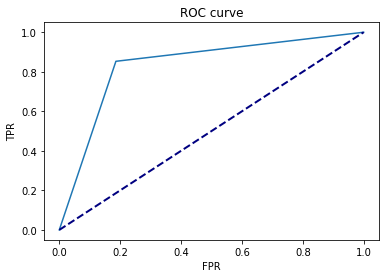

In [48]:
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.savefig('roc.png')
plt.show()

In [51]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[814 186]
 [147 853]]


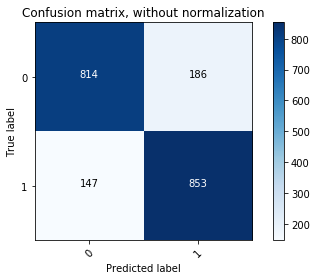

In [53]:
plt.figure()
plot_confusion_matrix(cm, classes=['0', '1'],
                      title='Confusion matrix, without normalization')
plt.savefig('cm.png')
plt.show()